### Notes

#### Music sources

I found this after doing the internet archive work. It is likely a better choice, since
it has a variety of genres, and is a single zip. https://github.com/mdeff/fma

MIDI dataset

http://colinraffel.com/projects/lmd/#get

#### Indexing music

The Shazam algorithm is somewhat complex, and has nothing to do with deep learning.  Are we sure we want to use it?

# Building a Shazam clone

This notebook will walk through the steps needed to build a (simple) Shazam clone.  We'll first gather some music files from the Internet Archive.  Alternatively you can use your own library.  We then read and index them to allow for quick searching.

## Downloading from the Internet Archive

We want to download a number of files from the hiphop mixtape collection of the Internet Archive.  This collection is a good starting point as it contains a large variety of music from diverse artists and has enough tracks that we can  tell if we're doing a good job or not.

The webpage for this collection is here:  https://archive.org/details/hiphopmixtapes

Fortunately, the IA provides an API to access it and a Python library has been created to wrap the API already.  This simplifies our work significantly.

In [8]:
import internetarchive as ia
import os
import itertools

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12, 8)
# Run this the first time you use the library.  You'll need to register an IA account:
# https://archive.org/account/login.createaccount.php
# ia.configure()

In [9]:
MUSIC_DIR = os.path.expanduser('~/.cache/dl-cookbook/mp3')

def download_collection(max_items):
    count = 0
    archive_session = ia.session.ArchiveSession()
    search = ia.search.Search(archive_session, 'collection:hiphopmixtapes')
    for r in search.iter_as_items():
        kept_files = [
            f for f in r.files
            if (f['name'].endswith('.mp3') and
                float(f['size']) > 1*1000*1000 and
                float(f['size']) < 10*1000*1000)
        ]
        
        if not kept_files:
            continue
        
        r.download(files=[f['name'] for f in kept_files], destdir=MUSIC_DIR)
        count += len([f for f in r.files if f['name'].endswith('.mp3')])
        if count > max_items:
            return
    
os.system('mkdir -p "%s"' % MUSIC_DIR)

# This will take quite a while, and will use a few gigs of disk space.
download_collection(50)

01.IntelligentHoodlum: ............ - success
01.NAOCHOREMEUAMOR: ............ - success
01.Rebel: ... - success
01.RoleModel: ........ - success
01.YamborghiniHighFt.ASAPRockyASAPFergASAPNastASAPAntASAPTwelvyyJuicyJ: .......... - success
01BandoleroRemix: ..... - success


# Processing our data

Now that we have downloaded all of our music files, we want to build a search index for them.  This means we have to process them in a way that we can look up the right track given a short, noisy snippet of audio.  The authors of Shazam fortunately detail the process they use in this paper.  We will mostly follow the same mechanism:

https://github.com/papers-we-love/papers-we-love/blob/master/audio_comp_sci/shazam-audio-search-algorithm.pdf

## Reading MP3 files

There are a number of programs and libraries available for working with audio files, in this case MP3.  We're going to use librosa; it's easy to install with pip and provides a number of helpful utility functions we can make use of.

In [32]:
import librosa
import librosa.display

SAMPLE_RATE = 22050

reality = librosa.load(
    MUSIC_DIR + '/01.IntelligentHoodlum/02. Back To Reality.mp3',
    sr=SAMPLE_RATE,
    mono=True,
    res_type='kaiser_fast',
    dtype='float32'
)

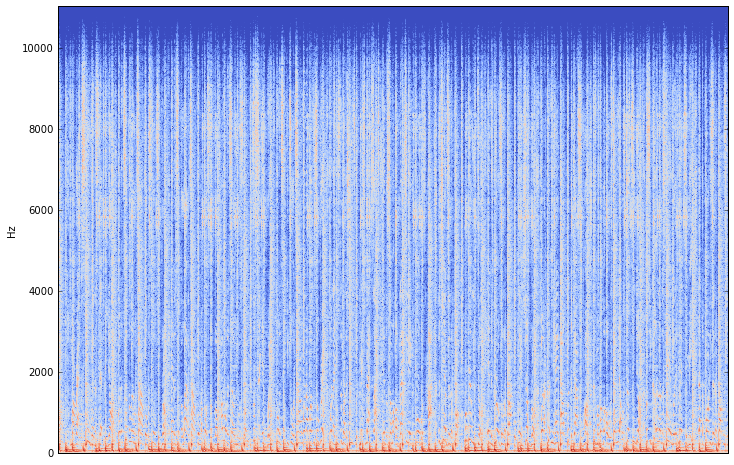

In [72]:
samples = reality[0]
spectrograph = librosa.core.stft(
    samples[SAMPLE_RATE*30:SAMPLE_RATE*60],
)

D = librosa.amplitude_to_db(spectrograph)
librosa.display.specshow(D, y_axis='linear')

In [100]:
samples.shape

(4886784,)

In [37]:
def play(sample):
    librosa.output.write_wav('/tmp/foo.wav', sample, SAMPLE_RATE)
    os.system('aplay /tmp/foo.wav')

In [104]:
# Let's generate a spectrogram for every 10 seconds of audio, for all of our audio files.
#
# We will use multiprocessing to speed things up.
import multiprocessing
import sys

SECONDS_PER_GRAPH = 10

os.system('mkdir -p "%s"' % SPECTOGRAPH_DIR)

def compute_spectographs(filename):
    samples = librosa.load(
        filename,
        sr=SAMPLE_RATE,
        mono=True,
        res_type='kaiser_fast',
        dtype='float32'
    )[0]
    
    output_prefix = filename + '.spectograph'
    
    for i, offset in enumerate(range(0, len(samples), SAMPLE_RATE * SECONDS_PER_GRAPH)):
        spectrograph = librosa.core.stft(samples[i:i+(SAMPLE_RATE*SECONDS_PER_GRAPH)])
        np.save(output_prefix + '.%03d' % i, spectrograph)
    
def compute_all():
    pool = multiprocessing.Pool()    
    mp3s = os.popen("find '%s' -name '*.mp3'" % MUSIC_DIR).read().split('\n')
    mp3s = [f for f in mp3s if f.endswith('.mp3')]
    
    pool.map(compute_spectographs, mp3s)
    pool.close()
    pool.join()
    return res

res = compute_all()

IsADirectoryError: [Errno 21] Is a directory: '/home/power/code/deep_learning_cookbook'

## Generating music with a GAN

In [71]:
import keras
import keras.layers as L
import keras.backend as K

# Using https://github.com/ctmakro/hellotensor/blob/master/lets_gan_clean.py
# as a basis

def gen_network(seed_shape):
    input = L.Input(shape=(seed_shape,))
    reshaped = L.Reshape((1,1,seed_shape))(input)
    def deconv(layer, num_filters, kernel_size, 
               strides=2, normalize=True, padding='same'):
        layer = L.Conv2DTranspose(
            num_filters, kernel_size, 
            padding=padding,
            strides=strides)(layer)
        print(K.int_shape(layer))
        if normalize:
            layer = L.BatchNormalization()(layer)
            layer = L.LeakyReLU(0.2)(layer)
        return layer

    reshaped = deconv(reshaped, 256, 4, padding='valid', strides=1)
    reshaped = deconv(reshaped, 128, 4, padding='same')
    reshaped = deconv(reshaped, 64, 4, padding='same')
    reshaped = deconv(reshaped, 32, 4, padding='same')
    reshaped = deconv(reshaped, 3, 4, normalize=False, strides=1)    
    return reshaped

def d

(None, 4, 4, 256)
(None, 8, 8, 128)
(None, 16, 16, 64)
(None, 32, 32, 32)
(None, 32, 32, 3)


In [60]:
K.int_shape(result)

(None, 1, 1, 32)